# Кластеризация
Задача сводится к поиску минимума отношения среднего расстояния между объектами в рамках кластера к среднему расстоянию между объектами разных кластеров. Объект может относиться как к одному кластеру (жёсткая кластеризация), так и к многом (мягкая).

Подготовким данные для кластеризации текстов. Для этого посчитаем TF-IDF.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data = {'rur rur eur usd eur', 'ooo ao pao ooo zao zao zao', 'ivan petr ivan evgenii sergey evgenii', 'pao zao pao zao ooo', 
        'ivan vasilii evgenii', 'usd usd usd eur eur'}
vectorizer = TfidfVectorizer(max_df =5, min_df=2)
matrix = vectorizer.fit_transform(data)

Словарь

In [3]:
vectorizer.get_feature_names()

['eur', 'evgenii', 'ivan', 'ooo', 'pao', 'usd', 'zao']

Матрица значений TF-IFD

In [4]:
matrix.data

array([ 0.89442719,  0.4472136 ,  0.70710678,  0.70710678,  0.53452248,
        0.26726124,  0.80178373,  0.33333333,  0.66666667,  0.66666667,
        0.70710678,  0.70710678,  0.5547002 ,  0.83205029])

#### Метод K средних
На входе подаётся число кластеров k. Далее выбирается k точек-центров. Остальные точки относят к тому кластеру, расстояние до центра которого минимально. Далее на каждой итерации считается среднее арифметическое, выбирается новый центр, обновляются метки точек. У данного метода есть модификация Bisect Means - на каждой итерации происходит разделение существующих кластеров на 2. Применяется на выпуклых кластерах схожего размера.

In [5]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=42)
preds = model.fit_predict(matrix.toarray())
print (list(preds))

[2, 1, 0, 0, 1, 2]


#### EM-алгоритм
На вход подаётся число компанент N. Плотность вероятности разспеределения точек p(x) представляет собой взвешенную сумму плотностей вероятности в каждом кластере $ p_j(x)$ с весами w (сумма весов = 1). Все $ p_j(x)$ выбираются из семейства распределений $\phi(\theta|x)$. Применяется в задаче восстановления плотности. Предполагаются выпуклые кластеры. Плохо масштабируется, нужна большая выборка.

E-шаг: вычисляется вероятность принадлежности каждой точки к кластеру $g_{ij} = p(\theta_j|x_i) = \frac{w_j * p_j(x_i)}{p(x_i)}$ и фиксируется.

M-шаг: обновляются параметры $\theta_j=argmax \sum{g_{ij} * ln_\phi(\theta|x)}$ и веса $w_j=\frac{1}{N*\sum{g_{ij}}}$

#### Метод но основе плотности точек
На вход подаётся радиус окрестности и количество соседей для основных точек. Точки делятся на основные (в окрестностях есть точки, количество > n), пограничные (в окрестностях есть точки, количество < n, но есть основная), остальные относятся к шумовым. Предполагаются неравные невыпуклые кластеры.

#### Иерархические методы
Делятся на агломеративные (объединение кластеров) и дивизионные (последовательное деление кластера). Агломеративная кластеризация используется в случае большого количества кластеров.

In [6]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
preds = model.fit_predict(matrix.toarray())
print (list(preds))

[0, 2, 1, 1, 2, 0]


# Задача размещения баннеров

In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
%matplotlib inline

#### Подготовка данных
Сформируем датасет из координат наиболее посещаемых мест по данным Foursquear

In [8]:
with open('checkins.dat','r') as file:
    next(file)
    next(file)
    df = pd.DataFrame(line.rstrip().split('|') for line in file)

df.columns = ['id','user_id','venue_id','latitude','longitude','created_at']
df.drop(df.tail(2).index, inplace=True)

df['latitude'] = df.latitude.apply(lambda x : x.lstrip().rstrip())
df['longitude'] = df.longitude.apply(lambda x : x.lstrip().rstrip())
df['created_at'] = df.created_at.apply(lambda x : x.lstrip().rstrip())
df = df[df.latitude != '']
df['latitude'] = df.latitude.astype(float)
df['longitude'] = df.longitude.astype(float)
df = df[['latitude','longitude']]

df.head()

,latitude,longitude
1,38.895112,-77.036366
3,33.800745,-84.410520
7,45.523452,-122.676207
9,40.764462,-111.904565
10,33.448377,-112.074037


Определим количество кластеров

In [11]:
ms = MeanShift(bandwidth=0.1)
ms.fit(df)
print("Number of clusters = ",len(np.unique(ms.labels_)))

Number of clusters =  5536


Визуализируем центры кластеров

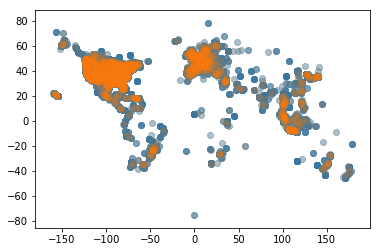

In [12]:
cluster_centers = ms.cluster_centers_
plt.scatter(df['longitude'],df['latitude'], alpha=0.4)
plt.scatter(cluster_centers[:,1],cluster_centers[:,0],alpha=0.1)
plt.show()

Отфильтруем менее посещаемые места

In [14]:
label_df = pd.DataFrame(ms.labels_, columns=['X'])
clusters = np.unique(label_df.groupby(['X']).filter(lambda x: len(x) > 15))